In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA

# 주성분 분석

## PCA 구현 및 실습

### 캘리포니아 주택 데이터(house) 전처리

In [2]:
# colab sample_data
house = pd.read_csv('/content/sample_data/california_housing_train.csv').iloc[:,:-1]
print(house.shape)
# 8차원

(17000, 8)


In [ ]:
house.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250


#### house 표준화

In [ ]:
# house는 특성에 따라 단위가 다르므로 표준화 필요
ss = StandardScaler()
house_scaled = ss.fit_transform(house)
house = pd.DataFrame(house_scaled, columns=house.columns)
house.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,2.619365,-0.671520,-1.079671,1.361695,1.764204,-0.361184,-0.075998,-1.252543
1,2.539569,-0.573264,-0.761872,2.296608,3.230441,-0.261865,-0.099404,-1.081483
2,2.494683,-0.905463,-0.920772,-0.882462,-0.866956,-0.955354,-0.999252,-1.170105
3,2.489696,-0.928857,-1.159121,-0.524186,-0.480230,-0.796793,-0.715774,-0.362600
4,2.489696,-0.961609,-0.682422,-0.545747,-0.506328,-0.701830,-0.622148,-1.026454


### house(8차원) PCA

#### KLT 함수 구현
- PCA와 근본적으로 같음(선형대수학의 고윳값분해 또는 특잇값분해로 구현됨)
- 축소된 데이터셋 행렬은 어떤 선형변환에 대응되는 행렬
- 복원된 데이터셋 행렬은 그 선형변환에 의해 원래 데이터셋 행렬을 변환한 행렬

In [ ]:
# 고윳값의 내림차순으로 대응되는 고유벡터를 정렬하는 방법 예시
A = np.array([10,2,4,5,2]) # 정렬되지 않은 고윳값 
B = np.array(['a','b','c','d','e']) # 그에 대응되는 고유벡터
ordering = np.argsort(A)[-1:-4:-1] # 고윳값의 내림차순 정렬을 위한 인덱스 순서; 가장 큰 3개
print(A[ordering])
print(B[ordering])
# 아래 코드에 적절히 사용

[10  5  4]
['a' 'd' 'c']


In [ ]:
def KLT(df, L): # PCA를 직접 구현해보는 의미; 입력은 (데이터셋, 축소할 차원 수)
  # 평균중심화
  X = df - df.mean()
  # 공분산 행렬의 고윳값과 고유벡터가 필요
  X_cov = np.cov(X, rowvar=False)
  eval, evec = np.linalg.eigh(X_cov) # 넘파이는 고유벡터를 열벡터로 반환하므로 이후 전치하여 사용
  # 이전 셀을 참고하여 내림차순 대응 정렬
  ordering = np.argsort(eval)[-1:-(L+1):-1] # 가장 큰 L개 내림차순
  var = eval[ordering] # 고윳값은 설명된 분산
  pc = np.transpose(evec)[ordering] # 고유벡터는 주성분
  
  ## 넘파이의 고유벡터와 사이킷런 pca의 주성분은 단위벡터이므로 크기는 1로 동일하지만 반대 방향일 수 있음
  ## 어떤 고유벡터를 선택하더라도 생성하는 부분공간은 동일하지만,
  ## 그 공간이 갖는 방향은 다를 수 있고 그 경우 내적의 부호가 반대가 되므로 
  ## 구현된 KLT 함수와 사이킷런 PCA 클래스에 의해 축소된 데이터셋의 원소가 부호는 다를 수 있음
  ## 단, 복원된 데이터셋은 동일해야 함
   
  # 행렬 W_L의 열이 고유벡터(주성분)
  W_L = np.transpose(pc)
  # 축소된 행렬 계산 T_L = X W_L (행렬곱)
  T_L = X @ W_L
  df_reduced = pd.DataFrame(T_L)
  # 복원된 행렬 계산 X_L = T_L pc
  X_L = T_L @ pc
  # 평균중심화 해제 및 특성 이름 복구
  X_L += df.mean().values
  df_recon = pd.DataFrame(X_L.values, columns=df.columns)
  # 축소된 데이터셋(특성 이름 없음), 복원된 데이터셋(특성 이름 있음) 튜플로 반환
  return df_reduced, df_recon

##### (참고)넘파이와 사이킷런의 고유벡터 부호 차이 예시

각 고유벡터끼리 부호가 다를 수도 있음을 확인

In [ ]:
# 넘파이
X = house - house.mean()
X_cov = np.cov(X, rowvar=False)
eval, evec = np.linalg.eigh(X_cov)
ordering = np.argsort(eval)[-1:-5:-1]
var = eval[ordering]
print(evec.T[ordering].round(4))

[[-0.079   0.0763  0.2182 -0.4832 -0.4902 -0.4724 -0.4916 -0.0417]
 [ 0.7008 -0.7013 -0.0207 -0.0775 -0.0635 -0.0298 -0.0658  0.0365]
 [ 0.0585 -0.0142  0.3897 -0.0975  0.1155  0.1148  0.1074 -0.8927]
 [-0.0664 -0.1028  0.8881  0.1154  0.0636  0.0841  0.097   0.4031]]


In [ ]:
# 사이킷런
pca = PCA(n_components=4)
hr = pca.fit_transform(house)
print(pca.components_.round(4)) # 주성분은 고유벡터

[[ 0.079  -0.0763 -0.2182  0.4832  0.4902  0.4724  0.4916  0.0417]
 [-0.7008  0.7013  0.0207  0.0775  0.0635  0.0298  0.0658 -0.0365]
 [-0.0585  0.0142 -0.3897  0.0975 -0.1155 -0.1148 -0.1074  0.8927]
 [-0.0664 -0.1028  0.8881  0.1154  0.0636  0.0841  0.097   0.4031]]


(참고)넘파이에는 np.linalg.eig과 np.linalg.eigh 함수가 존재하는데 추가된 글자 h는 함수가 받을 입력이 hermitian(에르미트) 행렬임을 의미한다. 이 행렬은 실수 체계에서 대칭행렬과 동일하므로 대칭행렬의 고윳값 및 고유벡터를 계산하기 위해 np.linalg.eigh를 쓰는 것이 효율적이다.
- 대칭행렬은 삼각행렬만 참조해도 되므로 더 원활한 알고리즘이 존재
- 차원이 큰 행렬에 대해서 np.linalg.eig를 사용해 계산하면 반올림 오차 등의 기술적 문제로 완전히 잘못된 값을 반환하기도 한다.

#### 차원 축소(8차원 $→$ 3차원)

직접 구현한 KLT와 사이킷런의 PCA를 비교

In [ ]:
# 사이킷런 PCA
pca = PCA(n_components=3)
h_3 = pd.DataFrame(pca.fit_transform(house))
h_3.head()

,0,1,2
0,1.756371,-2.081541,-0.881396
1,2.886282,-1.789440,-0.933482
2,-1.375555,-2.577270,-0.613384
3,-0.711540,-2.548927,0.141960
4,-0.773053,-2.532118,-0.656955


In [ ]:
# 직접 구현한 KLT
house_reduced, house_recon = KLT(house, 3) # 튜플 반환
house_reduced.head()

,0,1,2
0,-1.756371,2.081541,0.881396
1,-2.886282,1.789440,0.933482
2,1.375555,2.577270,0.613384
3,0.711540,2.548927,-0.141960
4,0.773053,2.532118,0.656955


축소된 데이터셋은 부호가 다를 수 있으므로 잘 구현되었음을 알 수 있다.

#### 데이터 복원(3차원 $→$ 8차원)

In [ ]:
# PCA
h_8 = pd.DataFrame(pca.inverse_transform(h_3), columns=house.columns)
h_8.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,1.649093,-1.606411,-0.082888,0.601401,0.830647,0.869006,0.821104,-0.637601
1,1.536741,-1.488516,-0.303044,1.164886,1.409111,1.417492,1.401337,-0.647638
2,1.733285,-1.711273,0.485679,-0.924108,-0.767107,-0.656158,-0.779833,-0.510867
3,1.721756,-1.731329,0.047066,-0.527413,-0.527017,-0.428345,-0.532712,0.190110
4,1.751811,-1.726202,0.372147,-0.633750,-0.463850,-0.365168,-0.476015,-0.526283


In [ ]:
# KLT
house_recon.head() # 반환된 튜플 중 복원된 데이터셋을 저장한 변수

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,1.649093,-1.606411,-0.082888,0.601401,0.830647,0.869006,0.821104,-0.637601
1,1.536741,-1.488516,-0.303044,1.164886,1.409111,1.417492,1.401337,-0.647638
2,1.733285,-1.711273,0.485679,-0.924108,-0.767107,-0.656158,-0.779833,-0.510867
3,1.721756,-1.731329,0.047066,-0.527413,-0.527017,-0.428345,-0.532712,0.190110
4,1.751811,-1.726202,0.372147,-0.633750,-0.463850,-0.365168,-0.476015,-0.526283


복원된 데이터셋은 이론적으로 완전히 동일해야 하므로 잘 구현되었음을 알 수 있다.(기술적으로는 근소한 차이가 날 수 있음)

#### 총 제곱 복원 오차(sum of square reconstruction error)
>$\|X-X_L\|_2^2=\|TW^T-T_LW_L^T\|_2^2$

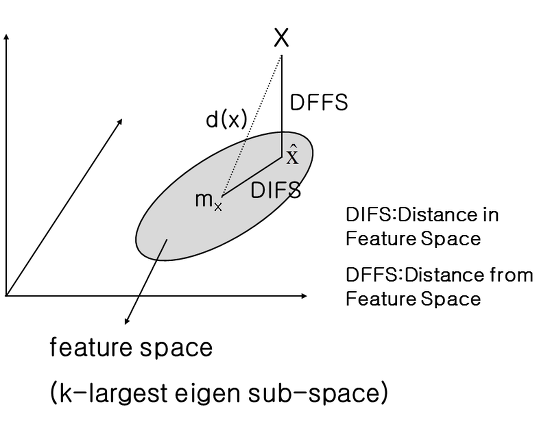

In [ ]:
# 데이터포인트의 오차벡터(벡터의 뺄셈)
error = house - house_recon # KLT로 복원된 데이터셋 사용
error

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.970272,0.934891,-0.996783,0.760294,0.933557,-1.230190,-0.897102,-0.614942
1,1.002828,0.915252,-0.458828,1.131721,1.821330,-1.679357,-1.500742,-0.433845
2,0.761398,0.805810,-1.406450,0.041646,-0.099850,-0.299196,-0.219419,-0.659238
3,0.767941,0.802472,-1.206187,0.003227,0.046786,-0.368447,-0.183062,-0.552710
4,0.737885,0.764593,-1.054569,0.088004,-0.042478,-0.336662,-0.146133,-0.500171
...,...,...,...,...,...,...,...,...
16995,-0.009911,-0.063834,1.024530,0.364723,0.024418,-0.000913,0.029276,0.414286
16996,-0.000782,-0.006966,0.094465,0.033965,0.050261,-0.028786,-0.018115,0.038201
16997,0.254826,0.296822,-1.008271,-0.111416,-0.055463,-0.079705,-0.162529,-0.452957
16998,0.232952,0.274632,-1.068728,-0.067806,-0.081380,-0.107098,-0.176520,-0.493749


In [ ]:
# 행벡터(오차벡터)의 크기의 제곱 : 데이터포인트별 제곱 복원 오차
dffs = (error**2).sum(axis=1)
dffs

0         6.954915
1        11.912598
2         3.791121
3         3.165534
4         2.635610
           ...    
16995     1.359945
16996     0.015269
16997     1.423078
16998     1.569507
16999     1.515104
Length: 17000, dtype: float64

In [ ]:
# 총 제곱 복원 오차
dffs.sum()

18850.74997477831

In [ ]:
# 평균 제곱 복원 오차
dffs.mean()
# PCA에서 내적의 분산을 최대로 하는 벡터를 찾는 것은 총 제곱 복원 오차의 최소화를 보장
# DIFS와 DFFS가 trade-off 관계이기 때문

1.1088676455751947

In [ ]:
# PCA로 복원된 데이터셋을 사용해서 총 및 평균 제곱 복원 오차를 출력
error = house - h_8 # PCA로 복원된 데이터셋 사용
dffs = (error**2).sum(axis=1)
print('총 제곱 복원 오차 :', dffs.sum())
print('평균 제곱 복원 오차 :', dffs.mean())

총 제곱 복원 오차 : 18850.749974778315
평균 제곱 복원 오차 : 1.108867645575195


KLT와 PCA의 제곱 복원 오차까지 거의 똑같이 나오는 것을 확인

즉, 이론적으로 h_3와 house_reduced는 동일하고, h_8과 house_recon은 동일하다. 

#### 주성분 간 비상관성 확인

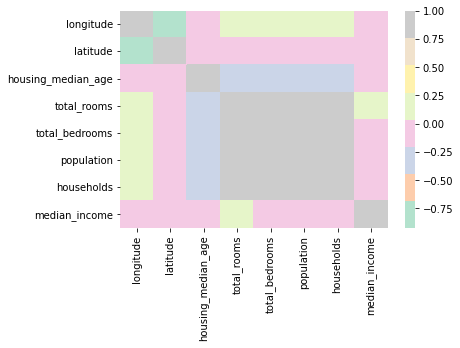

In [ ]:
# 원래 데이터셋에서 특성 간 상관관계
sns.heatmap(house.corr(), cmap='Pastel2'); # 상관계수 행렬

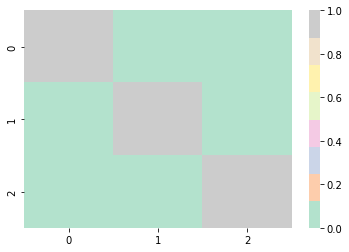

In [ ]:
# 축소된 데이터셋(h_3 또는 house_reduced)에서 특성(주성분) 간 상관관계
sns.heatmap(house_reduced.corr(), cmap='Pastel2');
# 주성분 간 공분산은 0이므로 상관계수 행렬이 단위행렬

#### 설명된 분산과 고윳값의 관계 검증

[3.91190715 1.90697568 1.0726549 ]


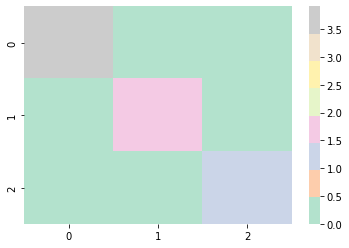

In [ ]:
# 축소된 데이터셋의 공분산 행렬 시각화; 이를 행 또는 열별로 정규화하면 상관계수 행렬
hr_cov = np.cov(house_reduced, rowvar=False)
print(np.diag(hr_cov)) # 주대각성분(np.diag 함수) 출력
sns.heatmap(hr_cov, cmap='Pastel2');
# 대각행렬
# 주대각성분이 내림차순 : 분산(고윳값)이 큰 순서대로 그 방향의 주성분(고유벡터)을 찾기 때문
# 주대각성분은 원래 데이터셋에 대한 공분산 행렬의 가장 큰 3개의 고윳값

In [ ]:
# 원래 데이터셋에 대한 공분산 행렬의 고윳값 계산
h_cov = np.cov(house, rowvar=False)
e_val, e_vec = np.linalg.eigh(h_cov) # (고윳값 리스트, 고유벡터 리스트) 반환
print(np.sort(e_val)[:-4:-1]) # 가장 큰 3개의 고윳값이 위에서 확인한 주대각성분임을 확인

[3.91190715 1.90697568 1.0726549 ]


#### 설명된 총 분산으로 주성분 개수 결정

3개의 주성분에 의해 설명되는 분산 

In [ ]:
print(pca.explained_variance_) # 위에서 구한 가장 큰 3개의 고윳값과 동일

[3.91190715 1.90697568 1.0726549 ]


In [ ]:
# 전체 분산에 대해 설명된 분산의 비율
print(pca.explained_variance_ratio_)
# 설명된 총 분산
print(f'설명된 총 분산 : {np.round(pca.explained_variance_ratio_.sum()*100, 1)}%')

[0.48895963 0.23835794 0.13407398]
설명된 총 분산 : 86.1%


90% 이상의 분산 설명력을 갖는 주성분 개수 찾기

8


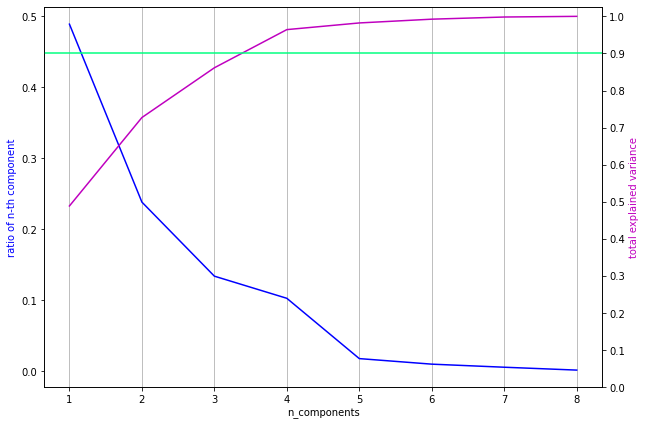

In [ ]:
# 위에서 확인한 결과 3개의 주성분은 86%의 분산을 설명하므로 다시 학습
# n_components를 지정하지 않고 학습한 다음 scree plot을 그려 90% 지점 확인
pca = PCA()
house_reduced = pca.fit_transform(house)
print(pca.n_components_) # 학습된 주성분의 개수 확인

# scree plot 겹쳐 그리기
fig, ax1 = plt.subplots(figsize=(10,7))

# 1. 각 주성분이 설명하는 분산 비율(파란색)
ax1.plot(np.arange(1,9,1), pca.explained_variance_ratio_, color='b')
ax1.set_xlabel('n_components')
ax1.set_ylabel('ratio of n-th component', color='b')
ax1.grid(axis='x')

# 2. n개의 주성분이 설명하는 총 분산 비율(자주색)
ax2 = ax1.twinx()
ax2.plot(np.arange(1,9,1), np.cumsum(pca.explained_variance_ratio_), color='m') # 누적합
ax2.set_ylabel('total explained variance', color='m')
ax2.set_yticks(np.arange(0,1.1,0.1))
ax2.axhline(y=0.9, color='springgreen')
plt.show()

# n_components를 지정하지 않아서 8개의 전체 주성분을 학습
# 분산의 90% 이상을 설명하려면 4개의 주성분 필요; 초록색과 자주색 교점 확인

In [ ]:
# n_components를 설명할 총 분산 비율의 임계값으로 지정 가능
# scree plot을 통해 확인한 결과와 같은지 확인 
pca = PCA(n_components=0.9)
house_reduced = pca.fit_transform(house)
print('전체 분산의 90% 이상을 설명하는 주성분의 개수 :', pca.n_components_) # 학습된 주성분 개수

전체 분산의 90% 이상을 설명하는 주성분의 개수 : 4


### KernelPCA

(1000, 2)


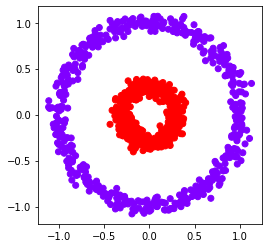

In [ ]:
from sklearn.datasets import make_circles # 2차원 데이터
X, col = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
print(X.shape) # col은 각 데이터가 속한 원의 정수 레이블
plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], c=col, cmap=plt.cm.rainbow);

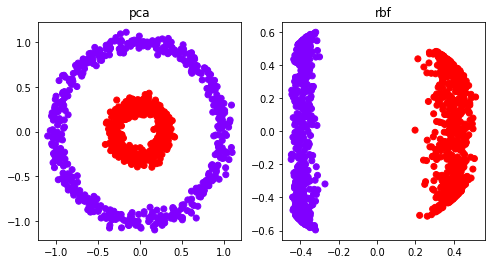

In [ ]:
pca = PCA(n_components=2)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=2, fit_inverse_transform=True)

plt.figure(figsize=(8,4))
for sub, model, name in [(121,pca,"pca"), (122,rbf_pca,"rbf")]:
  X_reduced = model.fit_transform(X)
  plt.subplot(sub)
  plt.title(name, fontsize=12)
  plt.scatter(X_reduced[:,0], X_reduced[:,1], c=col, cmap=plt.cm.rainbow)
plt.show() # rbf 커널이 적절

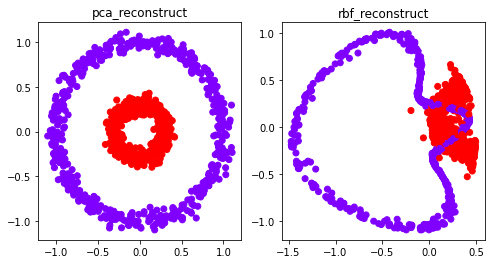

In [ ]:
plt.figure(figsize=(8,4))
for sub, model, name in [(121,pca,"pca_reconstruct"), (122,rbf_pca,"rbf_reconstruct")]:
  X_recon = model.inverse_transform(X)
  plt.subplot(sub)
  plt.title(name, fontsize=12)
  plt.scatter(X_recon[:,0], X_recon[:,1], c=col, cmap=plt.cm.rainbow)
plt.show() # 데이터의 복원이 잘 되지 않음

In [ ]:
from sklearn.datasets import make_swiss_roll # 3차원 데이터
X, col = make_swiss_roll(n_samples=1000, noise=0.2, random_state=0)
X.shape # col은 manifold 상에서의 주 차원에 대한 각 데이터의 일변량 위치 

(1000, 3)

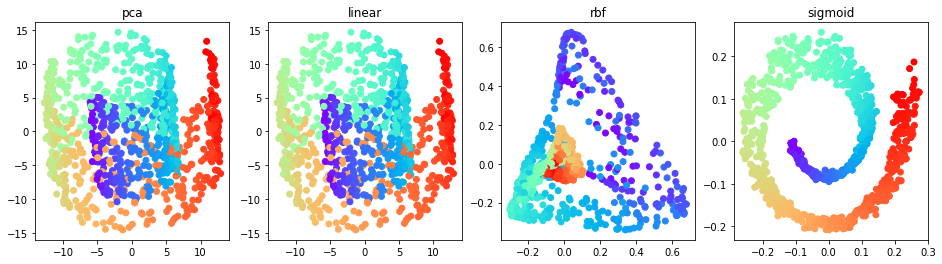

In [ ]:
pca = PCA(n_components=2)
lin_pca = KernelPCA(n_components=2, kernel="linear") # kernel='linear'이므로 pca와 동치
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.05)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1)

plt.figure(figsize=(16,4))
for sub, model, name in [(141,pca,"pca"), (142,lin_pca,"linear"), (143,rbf_pca,"rbf"), (144,sig_pca,"sigmoid")]:
  X_reduced = model.fit_transform(X)
  plt.subplot(sub)
  plt.title(name, fontsize=12)
  plt.scatter(X_reduced[:,0], X_reduced[:,1], c=col, cmap=plt.cm.rainbow)
plt.show()
# sigmoid 커널이 적절